In [8]:
import numpy as np
import scipy.io as sio
from pathlib import Path

# ==== CONFIGURACIÓN ====
roi_dir = Path('/home/diego/Escritorio/AAL3/ROISignals_AAL3_NiftiPreprocessedAllBatchesNorm')
mat_files = sorted(roi_dir.glob('ROISignals_*.mat'))

roi_counts = []
tp_counts  = []

for mat_path in mat_files:
    data = sio.loadmat(str(mat_path))
    if 'signals' not in data:
        raise KeyError(f"{mat_path.name} no contiene la variable 'signals'")
    sigs = np.asarray(data['signals'], dtype=float)

    # Suponemos: dim 0 = timepoints, dim 1 = ROIs
    tp, rois = sigs.shape

    tp_counts.append(tp)
    roi_counts.append(rois)

print("Valores únicos en roi_counts:", sorted(set(roi_counts)))
# Debería devolver: [170]



Valores únicos en roi_counts: [170]


In [9]:
EXPECTED_ROIS = 170
mismatches = []

for mat_path in mat_files:
    data = sio.loadmat(str(mat_path))
    sigs = np.asarray(data['signals'], dtype=float)
    d0, d1 = sigs.shape
    if d1 != EXPECTED_ROIS:
        mismatches.append((mat_path.name, sigs.shape))

if mismatches:
    print("Archivos sin 170 columnas en 'signals':")
    for name, shape in mismatches:
        print(f"  • {name:30s} shape={shape}")
else:
    print("✔️ Todos los archivos tienen 170 ROIs (dimensión 1).")




✔️ Todos los archivos tienen 170 ROIs (dimensión 1).


In [7]:
from scipy.io import whosmat

info = whosmat('/home/diego/Escritorio/AAL3/ROISignals_AAL3_NiftiPreprocessedAllBatchesNorm/ROISignals_002_S_0295.mat')
print(info)


[('signals', (140, 170), 'double')]


Time-points: min=140, max=200, media=177.0, mediana=197.0


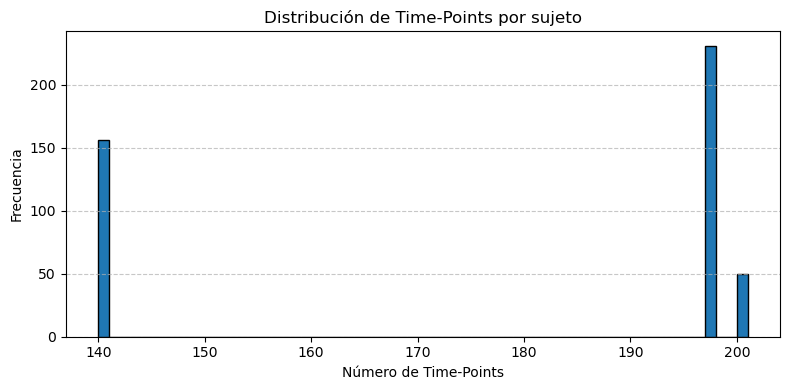

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que tp_counts ya está poblado
# tp_counts = [...]

# Estadísticas básicas
tp_array = np.array(tp_counts)
print(f"Time-points: min={tp_array.min()}, max={tp_array.max()}, media={tp_array.mean():.1f}, mediana={np.median(tp_array)}")

# Histograma
plt.figure(figsize=(8,4))
plt.hist(tp_array, bins=range(tp_array.min(), tp_array.max()+2), edgecolor='black')
plt.title('Distribución de Time-Points por sujeto')
plt.xlabel('Número de Time-Points')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

